## **MobileNet Approach for Deepfake Video Detection**

In [29]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path
import json
from torch.utils.data.sampler import WeightedRandomSampler

In [30]:
import os
import json
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
import wandb
from pathlib import Path
from tqdm import tqdm

In [ ]:
base_path = '/kaggle/input/celeb-df-v2'  # Adjust to your dataset path
output_path = '/kaggle/working/'
dim = 224
batch_size = 4
sequence_length = 10

# DataSet Creation

In [15]:
def create_dataset_splits(base_path, output_path, train_size=0.7, val_size=0.15, test_size=0.15, seed=42):
    real_videos = []
    fake_videos = []
    
    for folder in ['Celeb-real', 'YouTube-real']:
        folder_path = os.path.join(base_path, folder)
        videos = [os.path.join(folder, f) for f in os.listdir(folder_path) if f.endswith('.mp4')]
        real_videos.extend(videos)
    
    fake_folder = os.path.join(base_path, 'Celeb-synthesis')
    fake_videos = [os.path.join('Celeb-synthesis', f) for f in os.listdir(fake_folder) if f.endswith('.mp4')]
    
    fake_videos = fake_videos[:2000]  # Adjust as needed
    
    class_counts = {
        'real': len(real_videos),
        'fake': len(fake_videos)
    }
    print(f"Real videos: {class_counts['real']}, Fake videos: {class_counts['fake']}")
    
    splits_dict = {split: [] for split in ['train', 'val', 'test']}
    
    for videos, label in [(real_videos, 'real'), (fake_videos, 'fake')]:
        train_split, temp = train_test_split(videos, train_size=train_size, random_state=seed)
        relative_val_size = val_size / (val_size + test_size)
        val_split, test_split = train_test_split(temp, train_size=relative_val_size, random_state=seed)
        
        splits_dict['train'].extend(train_split)
        splits_dict['val'].extend(val_split)
        splits_dict['test'].extend(test_split)
    
    with open(os.path.join(output_path, 'splits.json'), 'w') as f:
        json.dump({
            'splits': splits_dict,
            'class_counts': class_counts
        }, f)
    
    return splits_dict, class_counts

In [16]:
class VideoDatasetSplit(Dataset):
    def __init__(self, base_path, split_path, split='train', sequence_length=10, transform=None):
        self.base_path = Path(base_path)
        self.sequence_length = sequence_length
        self.transform = transform
        
        with open(os.path.join(split_path, 'splits.json'), 'r') as f:
            data = json.load(f)
            self.videos = data['splits'][split]
            self.class_counts = data['class_counts']
    
    def get_sampler(self):
        weights = []
        max_samples = max(self.class_counts.values())
        
        for video_path in self.videos:
            is_fake = 'synthesis' in video_path
            count = self.class_counts['fake'] if is_fake else self.class_counts['real']
            weight = max_samples / count
            weights.append(weight)
        
        return WeightedRandomSampler(torch.DoubleTensor(weights), len(weights))
    
    def __getitem__(self, idx):
        video_path = self.videos[idx]
        label = 1 if 'synthesis' in video_path else 0
        
        frames = self.load_video(os.path.join(self.base_path, video_path))
        if self.transform:
            frames = torch.stack([self.transform(frame) for frame in frames])
        
        return frames, label
    
    def __len__(self):
        return len(self.videos)
    
    def load_video(self, video_path):
        frames = []
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        indices = np.linspace(0, total_frames-1, self.sequence_length, dtype=int)
        
        for frame_idx in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)
            else:
                frames.append(np.zeros(frames[-1].shape, dtype=np.uint8) if frames else np.zeros((224, 224, 3), dtype=np.uint8))
        
        cap.release()
        return np.stack(frames)

def create_dataloaders(base_path, output_path, dim, batch_size=4, sequence_length=10):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((dim, dim)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    splits_dict, class_counts = create_dataset_splits(base_path, output_path)
    
    train_dataset = VideoDatasetSplit(base_path, output_path, 'train', sequence_length, transform)
    val_dataset = VideoDatasetSplit(base_path, output_path, 'val', sequence_length, transform)
    test_dataset = VideoDatasetSplit(base_path, output_path, 'test', sequence_length, transform)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size,
        sampler=train_dataset.get_sampler(),
        num_workers=4,
        pin_memory=True
    )
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    return train_loader, val_loader, test_loader, class_counts

In [17]:
train_loader, val_loader, test_loader, class_counts = create_dataloaders(
    base_path, output_path, dim, batch_size, sequence_length
)

Real videos: 890, Fake videos: 2000


## Visualizing

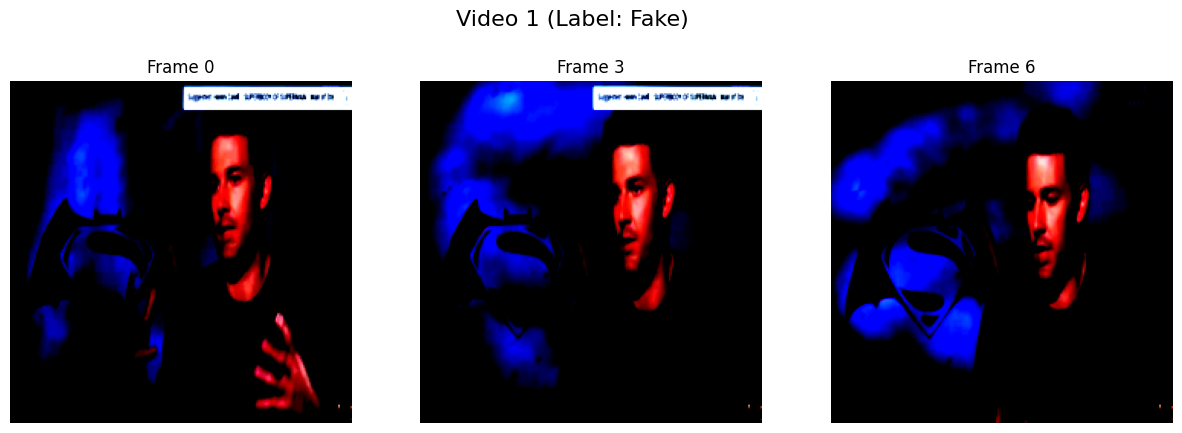

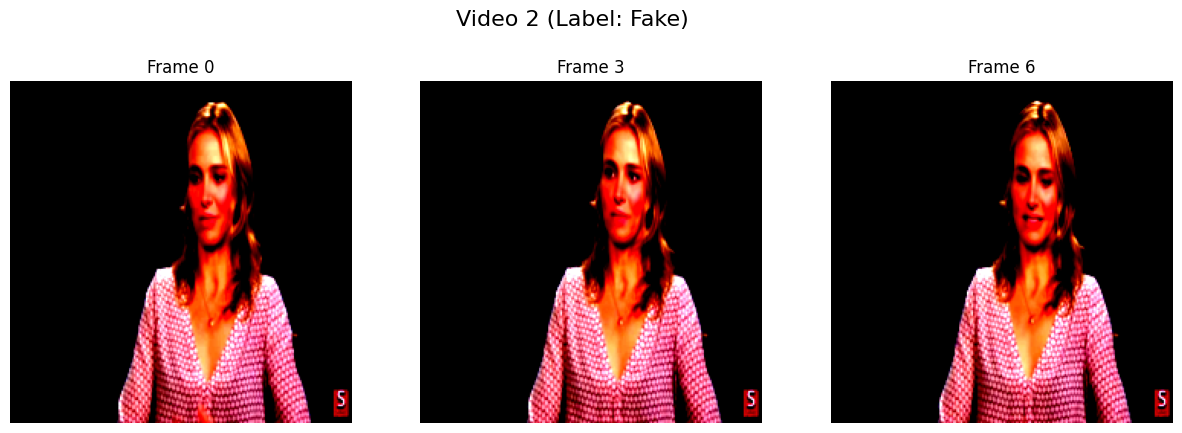

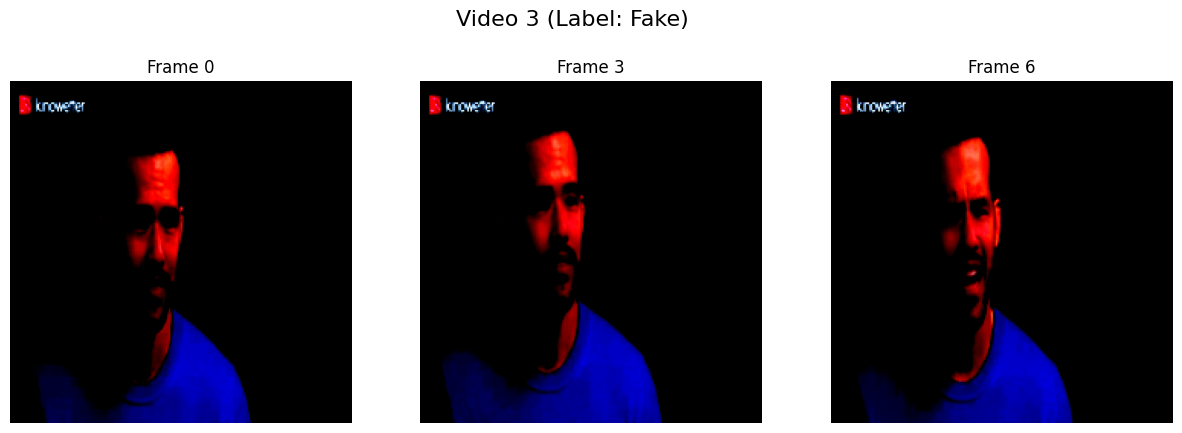

In [18]:
import matplotlib.pyplot as plt

def visualize_frames(data_loader, num_videos=2, num_frames=5):
    """
    Visualizes frames from videos in a batch.
    Args:
        data_loader: DataLoader object containing the video dataset.
        num_videos: Number of videos to visualize from the batch.
        num_frames: Number of frames to visualize per video.
    """
    # Fetch one batch of data
    batch = next(iter(data_loader))
    videos, labels = batch  # videos: [batch_size, sequence_length, C, H, W], labels: [batch_size]

    videos = videos[:num_videos]  # Take the first few videos
    labels = labels[:num_videos]

    for i, video in enumerate(videos):
        # Convert video tensor to numpy array and move channel to the last dimension
        video = video.permute(0, 2, 3, 1).numpy()  # Shape: [sequence_length, H, W, C]

        # Plot frames
        fig, axs = plt.subplots(1, num_frames, figsize=(15, 5))
        fig.suptitle(f"Video {i + 1} (Label: {'Fake' if labels[i] == 1 else 'Real'})", fontsize=16)
        
        for j in range(num_frames):
            frame_idx = int(j * (len(video) / num_frames))  # Select evenly spaced frames
            axs[j].imshow(video[frame_idx])
            axs[j].axis('off')
            axs[j].set_title(f"Frame {frame_idx}")
        
        plt.show()


visualize_frames(train_loader, num_videos=3, num_frames=3)

# Model Creation

In [21]:
class MobileNetV2Classifier(nn.Module):
    def __init__(self, num_classes=1, dropout=0.4):
        super().__init__()
        self.backbone = models.mobilenet_v2(weights=None)
        features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Linear(features, features // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(features // 2, num_classes),
            nn.Sigmoid() if num_classes == 1 else nn.Identity()
        )

    def forward(self, x, debug=False):
        batch, seq_len, channels, height, width = x.size()
        if debug:
            print(f"Input shape: {x.shape}")
        x = x.view(batch * seq_len, channels, height, width)
        if debug:
            print(f"Reshaped shape: {x.shape}")
        outputs = self.backbone(x)
        outputs = outputs.view(batch, seq_len, -1)
        outputs = outputs.mean(dim=1).squeeze()
        if isinstance(outputs, torch.Tensor) and outputs.dim() == 0:
            outputs = outputs.unsqueeze(0)
        return outputs

In [22]:
class VideoTrainer:
    def __init__(
        self,
        model,
        train_loader,
        val_loader,
        test_loader,
        learning_rate=1e-4,
        weight_decay=0.01,
        epochs=5,
        device='cuda',
        use_wandb=False,
        model_save_dir='models',
        model_prefix=''
    ):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        self.epochs = epochs
        self.use_wandb = use_wandb
        self.model_save_dir = model_save_dir
        self.model_prefix = model_prefix
        self.metrics = []
        self.criterion = nn.BCELoss()  # Changed to BCELoss since Sigmoid is in model
        self.optimizer = AdamW(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )
        self.scheduler = CosineAnnealingLR(
            self.optimizer,
            T_max=epochs,
            eta_min=learning_rate/100
        )
        os.makedirs(model_save_dir, exist_ok=True)
        if use_wandb:
            self._init_wandb()

    def _init_wandb(self):
        wandb.init(
            project="deepfake-detection",
            config={
                "architecture": self.model.__class__.__name__,
                "backbone": self.model_prefix,
                "epochs": self.epochs,
                "batch_size": self.train_loader.batch_size,
            }
        )

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        predictions, targets = [], []
        
        # Use tqdm for progress bar
        for batch_idx, (videos, labels) in tqdm(enumerate(self.train_loader), total=len(self.train_loader), desc="Training"):
            # Debug print only for first batch
            if batch_idx == 0:
                print(f"Batch videos shape: {videos.shape}, Labels shape: {labels.shape}")
            videos, labels = videos.to(self.device), labels.to(self.device).float()
            self.optimizer.zero_grad()
            # Pass debug=True only for first batch
            outputs = self.model(videos, debug=(batch_idx == 0))
            loss = self.criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            running_loss += loss.item()
            predictions.extend(outputs.detach().cpu().numpy())
            targets.extend(labels.cpu().numpy())
            
        metrics = self._calculate_metrics(predictions, targets)
        metrics['loss'] = running_loss / len(self.train_loader)
        print(f"Train Epoch Loss: {metrics['loss']:.4f}")
        return metrics

    def validate(self, mode='val'):
        self.model.eval()
        running_loss = 0.0
        predictions, targets = [], []
        loader = self.val_loader if mode == 'val' else self.test_loader
        with torch.no_grad():
            for videos, labels in tqdm(loader, total=len(loader), desc="Validating" if mode == 'val' else "Testing"):
                videos, labels = videos.to(self.device), labels.to(self.device).float()
                outputs = self.model(videos)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()
                predictions.extend(outputs.cpu().numpy())
                targets.extend(labels.cpu().numpy())
        metrics = self._calculate_metrics(predictions, targets)
        if mode == 'val':
            metrics['loss'] = running_loss / len(self.val_loader)
            print(f"Validation Epoch Loss: {metrics['loss']:.4f}")
        return metrics

    def _calculate_metrics(self, predictions, targets):
        predictions = np.array(predictions)
        targets = np.array(targets)
        binary_preds = (predictions > 0.5).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(
            targets, binary_preds, average='binary', zero_division=0
        )
        auc = roc_auc_score(targets, predictions)
        return {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc
        }

    def train(self):
        best_val_auc = 0
        for epoch in range(self.epochs):
            print(f"\nEpoch {epoch + 1}/{self.epochs}")
            train_metrics = self.train_epoch()
            val_metrics = self.validate()
            self.scheduler.step()
            
            if val_metrics['auc'] > best_val_auc:
                best_val_auc = val_metrics['auc']
                self.save_model(f'{self.model_prefix}_best_model.pth')
            
            metrics = {
                'train': train_metrics,
                'val': val_metrics,
                'epoch': epoch + 1
            }
            self._log_metrics(metrics)
        
        self.save_model(f'{self.model_prefix}_final_model.pth')
        print(f"\n[Running {self.model_prefix} on TEST SET]")
        print('-'*80)
        test_metrics = self.validate('test')
        print(test_metrics)

    def save_model(self, filename):
        model_path = os.path.join(self.model_save_dir, filename)
        torch.save(self.model.module.state_dict() if isinstance(self.model, torch.nn.DataParallel) else self.model.state_dict(), model_path)
        
        metadata = {
            'model_class': self.model.__class__.__name__,
            'num_classes': 1,
            'dropout': 0.4,
            'backbone': self.model_prefix
        }
        metadata_path = os.path.join(self.model_save_dir, f"{filename.split('.')[0]}_metadata.json")
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=4)

    def _log_metrics(self, metrics):
        print(f"Epoch {metrics['epoch']}/{self.epochs}")
        for phase in ['train', 'val']:
            print(f"{phase.capitalize()} - ", end="")
            phase_metrics = metrics[phase]
            metric_str = " | ".join(
                f"{k}: {v:.4f}" for k, v in phase_metrics.items()
            )
            print(metric_str)
        self.metrics.append(metrics)
        if self.use_wandb:
            wandb.log({
                f"{phase}_{k}": v 
                for phase in ['train', 'val']
                for k, v in metrics[phase].items()
            })

In [23]:
def train_model(train_loader, val_loader, test_loader, config=None):
    if config is None:
        config = {
            'learning_rate': 0.0001,
            'weight_decay': 0.01,
            'epochs': 10,
            'device': 'cuda' if torch.cuda.is_available() else 'cpu',
            'use_wandb': False,
            'model_save_dir': '/kaggle/working/models'
        }
    
    # Initialize MobileNetV2
    model = MobileNetV2Classifier()
    model = torch.nn.DataParallel(model)
    trainer = VideoTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        learning_rate=config['learning_rate'],
        weight_decay=config['weight_decay'],
        epochs=config['epochs'],
        device=config['device'],
        use_wandb=config['use_wandb'],
        model_save_dir=config['model_save_dir'],
        model_prefix='mobilenetv2'
    )
    
    trainer.train()
    return model, trainer.metrics

In [31]:
model, metrics = train_model(train_loader, val_loader, test_loader)


Epoch 1/10


Training:   0%|          | 0/506 [00:00<?, ?it/s]

Batch videos shape: torch.Size([4, 10, 3, 224, 224]), Labels shape: torch.Size([4])
Input shape: torch.Size([2, 10, 3, 224, 224])
Reshaped shape: torch.Size([20, 3, 224, 224])
Input shape: torch.Size([2, 10, 3, 224, 224])
Reshaped shape: torch.Size([20, 3, 224, 224])


Training: 100%|██████████| 506/506 [03:38<00:00,  2.32it/s]


Train Epoch Loss: 0.7006


Validating: 100%|██████████| 109/109 [00:47<00:00,  2.31it/s]

Validation Epoch Loss: 0.8076
Epoch 1/10
Train - precision: 0.5307 | recall: 0.4414 | f1: 0.4820 | auc: 0.5445 | loss: 0.7006
Val - precision: 0.7433 | recall: 0.6467 | f1: 0.6916 | auc: 0.6039 | loss: 0.8076

Epoch 2/10



Training:   0%|          | 0/506 [00:00<?, ?it/s]

Batch videos shape: torch.Size([4, 10, 3, 224, 224]), Labels shape: torch.Size([4])
Input shape: torch.Size([2, 10, 3, 224, 224])
Input shape: torch.Size([2, 10, 3, 224, 224])
Reshaped shape: torch.Size([20, 3, 224, 224])
Reshaped shape: torch.Size([20, 3, 224, 224])


Training: 100%|██████████| 506/506 [03:36<00:00,  2.34it/s]


Train Epoch Loss: 0.6959


Validating: 100%|██████████| 109/109 [00:44<00:00,  2.46it/s]

Validation Epoch Loss: 0.7791
Epoch 2/10
Train - precision: 0.5387 | recall: 0.5845 | f1: 0.5607 | auc: 0.5439 | loss: 0.6959
Val - precision: 0.7569 | recall: 0.5500 | f1: 0.6371 | auc: 0.6260 | loss: 0.7791

Epoch 3/10



Training:   0%|          | 0/506 [00:00<?, ?it/s]

Batch videos shape: torch.Size([4, 10, 3, 224, 224]), Labels shape: torch.Size([4])
Input shape: torch.Size([2, 10, 3, 224, 224])
Reshaped shape: torch.Size([20, 3, 224, 224])
Input shape: torch.Size([2, 10, 3, 224, 224])
Reshaped shape: torch.Size([20, 3, 224, 224])


Training: 100%|██████████| 506/506 [03:33<00:00,  2.37it/s]


Train Epoch Loss: 0.6764


Validating: 100%|██████████| 109/109 [00:44<00:00,  2.47it/s]


Validation Epoch Loss: 0.6515
Epoch 3/10
Train - precision: 0.5717 | recall: 0.5661 | f1: 0.5689 | auc: 0.5930 | loss: 0.6764
Val - precision: 0.7645 | recall: 0.8333 | f1: 0.7974 | auc: 0.6426 | loss: 0.6515

Epoch 4/10


Training:   0%|          | 0/506 [00:00<?, ?it/s]

Batch videos shape: torch.Size([4, 10, 3, 224, 224]), Labels shape: torch.Size([4])
Input shape: torch.Size([2, 10, 3, 224, 224])
Reshaped shape: torch.Size([20, 3, 224, 224])
Input shape: torch.Size([2, 10, 3, 224, 224])
Reshaped shape: torch.Size([20, 3, 224, 224])


Training: 100%|██████████| 506/506 [03:34<00:00,  2.36it/s]


Train Epoch Loss: 0.6559


Validating: 100%|██████████| 109/109 [00:44<00:00,  2.45it/s]

Validation Epoch Loss: 0.8135
Epoch 4/10
Train - precision: 0.6113 | recall: 0.6131 | f1: 0.6122 | auc: 0.6471 | loss: 0.6559
Val - precision: 0.7643 | recall: 0.7133 | f1: 0.7379 | auc: 0.6525 | loss: 0.8135

Epoch 5/10



Training:   0%|          | 0/506 [00:00<?, ?it/s]

Batch videos shape: torch.Size([4, 10, 3, 224, 224]), Labels shape: torch.Size([4])
Input shape: torch.Size([2, 10, 3, 224, 224])
Reshaped shape: torch.Size([20, 3, 224, 224])
Input shape: torch.Size([2, 10, 3, 224, 224])
Reshaped shape: torch.Size([20, 3, 224, 224])


Training: 100%|██████████| 506/506 [03:34<00:00,  2.36it/s]


Train Epoch Loss: 0.6449


Validating: 100%|██████████| 109/109 [00:44<00:00,  2.44it/s]

Validation Epoch Loss: 0.6125
Epoch 5/10
Train - precision: 0.6109 | recall: 0.7180 | f1: 0.6601 | auc: 0.6519 | loss: 0.6449
Val - precision: 0.7354 | recall: 0.9267 | f1: 0.8201 | auc: 0.6322 | loss: 0.6125

Epoch 6/10



Training:   0%|          | 0/506 [00:00<?, ?it/s]

Batch videos shape: torch.Size([4, 10, 3, 224, 224]), Labels shape: torch.Size([4])
Input shape: torch.Size([2, 10, 3, 224, 224])
Input shape: torch.Size([2, 10, 3, 224, 224])
Reshaped shape: torch.Size([20, 3, 224, 224])
Reshaped shape: torch.Size([20, 3, 224, 224])


Training: 100%|██████████| 506/506 [03:33<00:00,  2.37it/s]


Train Epoch Loss: 0.6507


Validating: 100%|██████████| 109/109 [00:44<00:00,  2.47it/s]

Validation Epoch Loss: 0.6522
Epoch 6/10
Train - precision: 0.5795 | recall: 0.7009 | f1: 0.6344 | auc: 0.6474 | loss: 0.6507
Val - precision: 0.7389 | recall: 0.8867 | f1: 0.8061 | auc: 0.6215 | loss: 0.6522

Epoch 7/10



Training:   0%|          | 0/506 [00:00<?, ?it/s]

Batch videos shape: torch.Size([4, 10, 3, 224, 224]), Labels shape: torch.Size([4])
Input shape: torch.Size([2, 10, 3, 224, 224])
Reshaped shape: torch.Size([20, 3, 224, 224])
Input shape: torch.Size([2, 10, 3, 224, 224])
Reshaped shape: torch.Size([20, 3, 224, 224])


Training: 100%|██████████| 506/506 [03:33<00:00,  2.37it/s]


Train Epoch Loss: 0.6335


Validating: 100%|██████████| 109/109 [00:44<00:00,  2.44it/s]

Validation Epoch Loss: 0.7427
Epoch 7/10
Train - precision: 0.6134 | recall: 0.7765 | f1: 0.6854 | auc: 0.6608 | loss: 0.6335
Val - precision: 0.7556 | recall: 0.7933 | f1: 0.7740 | auc: 0.6287 | loss: 0.7427

Epoch 8/10



Training:   0%|          | 0/506 [00:00<?, ?it/s]

Batch videos shape: torch.Size([4, 10, 3, 224, 224]), Labels shape: torch.Size([4])
Input shape: torch.Size([2, 10, 3, 224, 224])
Reshaped shape: torch.Size([20, 3, 224, 224])
Input shape: torch.Size([2, 10, 3, 224, 224])
Reshaped shape: torch.Size([20, 3, 224, 224])


Training: 100%|██████████| 506/506 [03:32<00:00,  2.38it/s]


Train Epoch Loss: 0.6218


Validating: 100%|██████████| 109/109 [00:44<00:00,  2.44it/s]

Validation Epoch Loss: 0.6145
Epoch 8/10
Train - precision: 0.6038 | recall: 0.7666 | f1: 0.6756 | auc: 0.6637 | loss: 0.6218
Val - precision: 0.7389 | recall: 0.9433 | f1: 0.8287 | auc: 0.6386 | loss: 0.6145

Epoch 9/10



Training:   0%|          | 0/506 [00:00<?, ?it/s]

Batch videos shape: torch.Size([4, 10, 3, 224, 224]), Labels shape: torch.Size([4])
Input shape: torch.Size([2, 10, 3, 224, 224])
Reshaped shape: torch.Size([20, 3, 224, 224])
Input shape: torch.Size([2, 10, 3, 224, 224])
Reshaped shape: torch.Size([20, 3, 224, 224])


Training: 100%|██████████| 506/506 [03:33<00:00,  2.37it/s]


Train Epoch Loss: 0.6087


Validating: 100%|██████████| 109/109 [00:45<00:00,  2.42it/s]

Validation Epoch Loss: 0.6751
Epoch 9/10
Train - precision: 0.6278 | recall: 0.7953 | f1: 0.7017 | auc: 0.6975 | loss: 0.6087
Val - precision: 0.7471 | recall: 0.8567 | f1: 0.7981 | auc: 0.6453 | loss: 0.6751

Epoch 10/10



Training:   0%|          | 0/506 [00:00<?, ?it/s]

Batch videos shape: torch.Size([4, 10, 3, 224, 224]), Labels shape: torch.Size([4])
Input shape: torch.Size([2, 10, 3, 224, 224])
Reshaped shape: torch.Size([20, 3, 224, 224])
Input shape: torch.Size([2, 10, 3, 224, 224])
Reshaped shape: torch.Size([20, 3, 224, 224])


Training: 100%|██████████| 506/506 [03:33<00:00,  2.37it/s]


Train Epoch Loss: 0.6251


Validating: 100%|██████████| 109/109 [00:45<00:00,  2.39it/s]


Validation Epoch Loss: 0.6379
Epoch 10/10
Train - precision: 0.5926 | recall: 0.7250 | f1: 0.6522 | auc: 0.6815 | loss: 0.6251
Val - precision: 0.7439 | recall: 0.9200 | f1: 0.8227 | auc: 0.6419 | loss: 0.6379

[Running mobilenetv2 on TEST SET]
--------------------------------------------------------------------------------


Testing: 100%|██████████| 109/109 [00:44<00:00,  2.42it/s]

{'precision': 0.7328042328042328, 'recall': 0.9233333333333333, 'f1': 0.8171091445427728, 'auc': 0.6048507462686566}


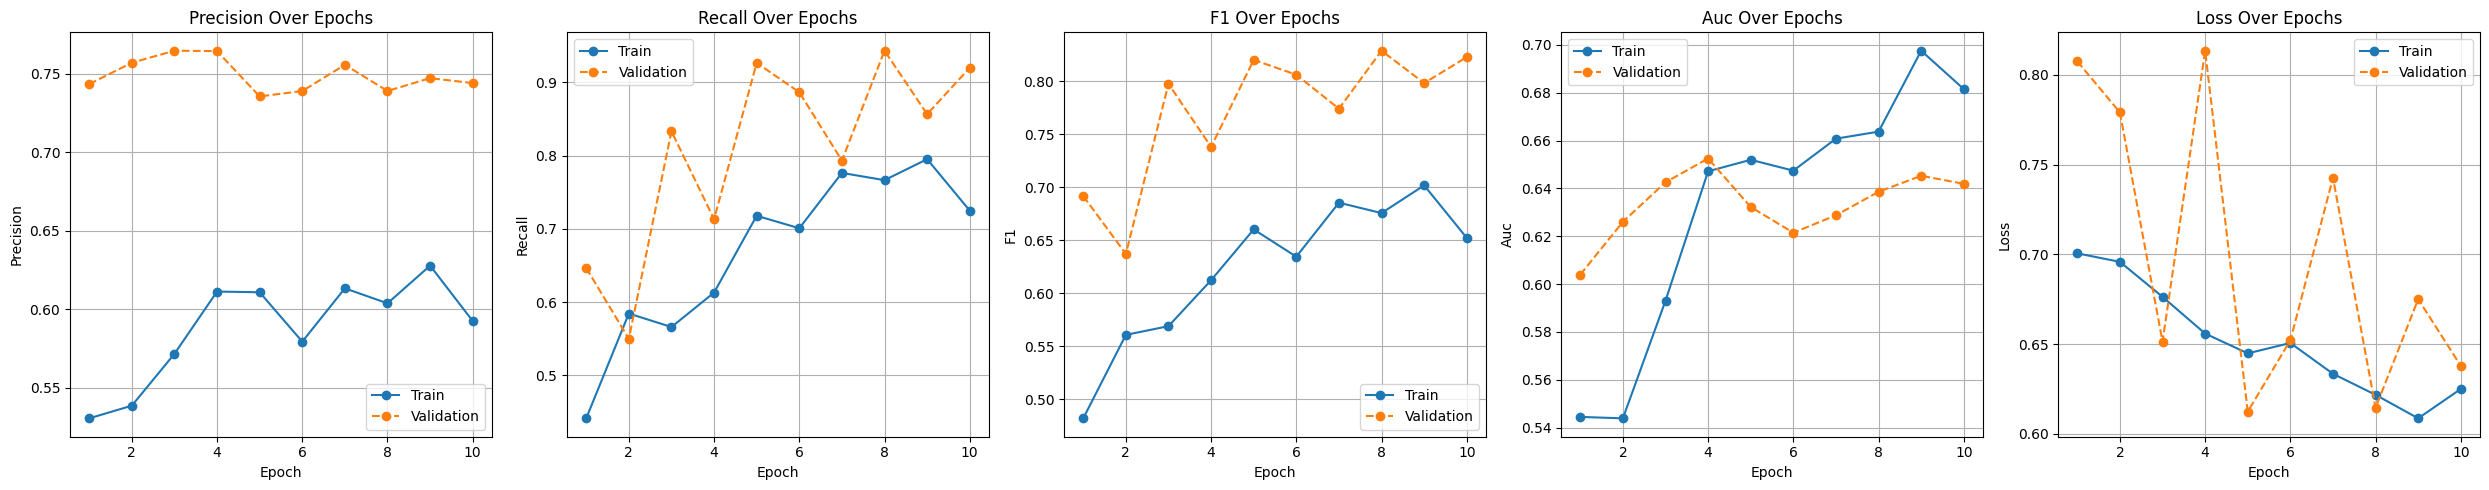

In [32]:
# import matplotlib.pyplot as plt

def visualize_metrics(metrics):
    """Args:
        metrics (list of dict): List containing dictionaries of training and validation metrics per epoch.
    """
    # Extract epochs, training, and validation metrics
    epochs = [entry['epoch'] for entry in metrics]
    train_metrics = {key: [entry['train'][key] for entry in metrics] for key in metrics[0]['train']}
    val_metrics = {key: [entry['val'][key] for entry in metrics] for key in metrics[0]['val']}

    # List of metric names
    metric_names = list(train_metrics.keys())

    # Set up the plots
    num_metrics = len(metric_names)
    fig, axes = plt.subplots(1, num_metrics, figsize=(5 * num_metrics, 5))
    if num_metrics == 1:
        axes = [axes]  # Ensure axes is iterable when there's only one plot

    for i, metric_name in enumerate(metric_names):
        axes[i].plot(epochs, train_metrics[metric_name], label='Train', marker='o')
        axes[i].plot(epochs, val_metrics[metric_name], label='Validation', marker='o', linestyle='--')
        axes[i].set_title(f"{metric_name.capitalize()} Over Epochs")
        axes[i].set_xlabel("Epoch")
        axes[i].set_ylabel(metric_name.capitalize())
        axes[i].legend()
        axes[i].grid(True)

    save_path="/kaggle/working/metrics_plot.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

# Example Usage

visualize_metrics(metrics)

In [33]:
import torch
import numpy as np
from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    roc_curve
)
import matplotlib.pyplot as plt


class ModelEvaluator:
    def __init__(self, model, test_loader, device="cuda", class_names=None):
        """
        Initialize the evaluator with the model and test data loader.
        Args:
            model (torch.nn.Module): The trained model to evaluate.
            test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
            device (str): The device to use for evaluation (default: "cuda").
            class_names (list): List of class names for the confusion matrix.
        """
        self.model = model.to(device)
        self.test_loader = test_loader
        self.device = device
        self.class_names = class_names or ["Class 0", "Class 1"]
        self.predictions = []
        self.targets = []
        self.samples = []
        self.threshold = 0.59

    def evaluate(self):
        """Evaluate the model on the test dataset."""
        self.model.eval()
        with torch.no_grad():
            for videos, labels in self.test_loader:
                videos, labels = videos.to(self.device), labels.to(self.device)
                outputs = self.model(videos)
                probs = torch.sigmoid(outputs).cpu().numpy()  # Convert logits to probabilities
                self.predictions.extend(probs)
                self.targets.extend(labels.cpu().numpy())
                self.samples.extend(videos.cpu().numpy())
        
        self.predictions = np.array(self.predictions).squeeze()
        self.targets = np.array(self.targets).squeeze()
        self.samples = np.array(self.samples)
        return self._calculate_metrics()

    def _calculate_metrics(self):
        """Calculates precision, recall, F1, AUC, and accuracy."""
        binary_preds = (self.predictions > self.threshold).astype(int)

        # Metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            self.targets, binary_preds, average="binary"
        )
        auc = roc_auc_score(self.targets, self.predictions)
        acc = accuracy_score(self.targets, binary_preds)

        return {
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "auc": auc,
            "accuracy": acc,
        }

    def plot_confusion_matrix(self):
        """Plots the confusion matrix."""
        binary_preds = (self.predictions > self.threshold).astype(int)
        cm = confusion_matrix(self.targets, binary_preds, labels=range(len(self.class_names)))

        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.class_names)
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.show()

    def plot_roc_curve(self):
        """Plots the ROC curve and AUC."""
        fpr, tpr, _ = roc_curve(self.targets, self.predictions)

        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='b', label=f'ROC Curve (AUC = {self._calculate_metrics()["auc"]:.4f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()

    def plot_examples(self, num_examples=5):
        """
        Plots examples of misclassifications and correct classifications.
        Args:
            num_examples (int): Number of examples to display for each case.
        """
        binary_preds = (self.predictions > self.threshold).astype(int)
        misclassified_indices = np.where(binary_preds != self.targets)[0]
        correctly_classified_indices = np.where(binary_preds == self.targets)[0]

        def plot_samples(indices, title, num_examples):
            indices = np.random.choice(indices, size=min(len(indices), num_examples), replace=False)
            fig, axes = plt.subplots(1, len(indices), figsize=(15, 5))
            fig.suptitle(title, fontsize=16)
            if len(indices) == 1:  # Handle single subplot case
                axes = [axes]
            for ax, idx in zip(axes, indices):
                sample = self.samples[idx]
                label = self.targets[idx]
                pred = binary_preds[idx]

                # Show a single frame from the video for simplicity
                ax.imshow(sample[0, 0], cmap="gray")  # Assuming single-channel grayscale images
                ax.set_title(f"True: {self.class_names[int(label)]}\nPred: {self.class_names[int(pred)]}")
                ax.axis("off")
            plt.show()

        if len(misclassified_indices) > 0:
            plot_samples(misclassified_indices, "Misclassified Examples", num_examples)
        else:
            print("No misclassified examples found.")

        if len(correctly_classified_indices) > 0:
            plot_samples(correctly_classified_indices, "Correctly Classified Examples", num_examples)
        else:
            print("No correctly classified examples found.")

    def display_metrics(self):
        """Calculate and display metrics, confusion matrix, and examples."""
        print("Evaluating Model...")
        metrics = self.evaluate()

        print("\nMetrics:")
        for key, value in metrics.items():
            print(f"{key.capitalize()}: {value:.4f}")

        print("\nPlotting Confusion Matrix...")
        self.plot_confusion_matrix()

        print("\nDisplaying Examples...")
        self.plot_examples()

        print("\nPlotting ROC Curve...")
        self.plot_roc_curve()

In [34]:
evaluator = ModelEvaluator(model,test_loader,class_names=['Real','Fake'])

Evaluating Model...

Metrics:
Precision: 0.7352
Recall: 0.9533
F1: 0.8302
Auc: 0.6049
Accuracy: 0.7304

Plotting Confusion Matrix...


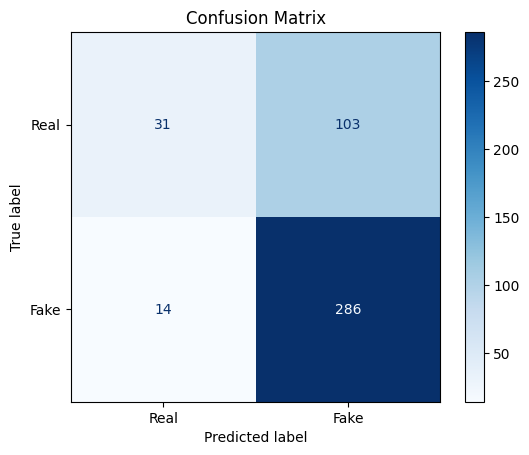


Displaying Examples...


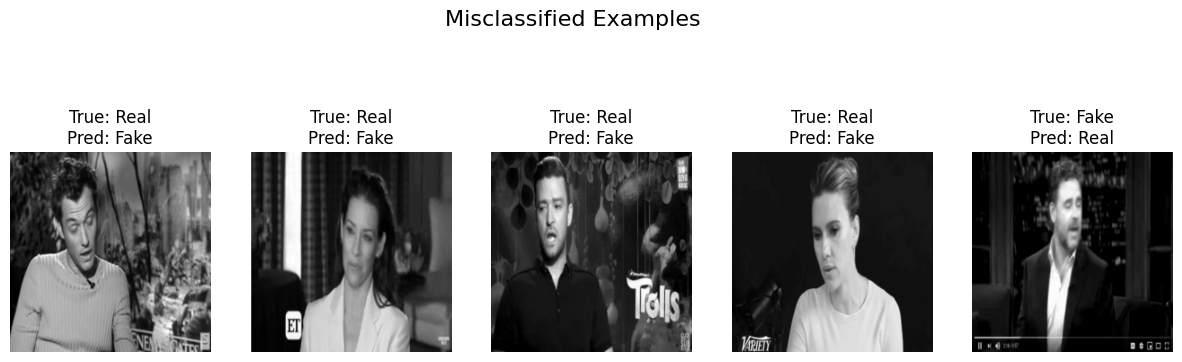

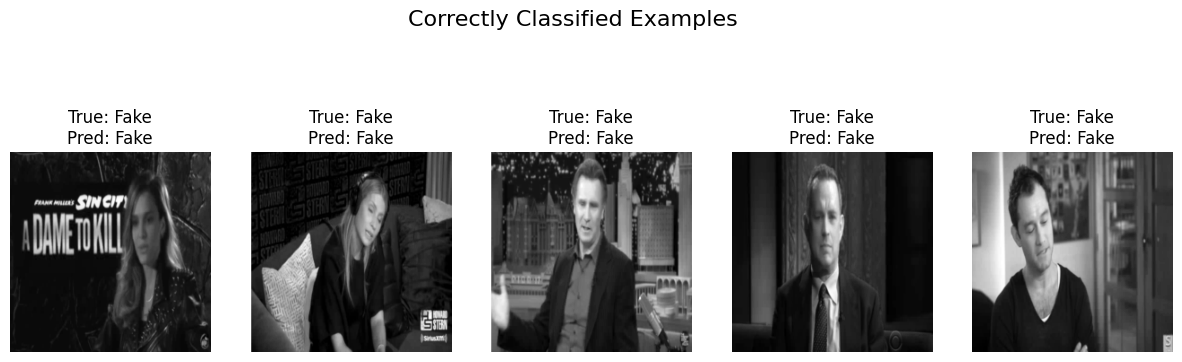


Plotting ROC Curve...


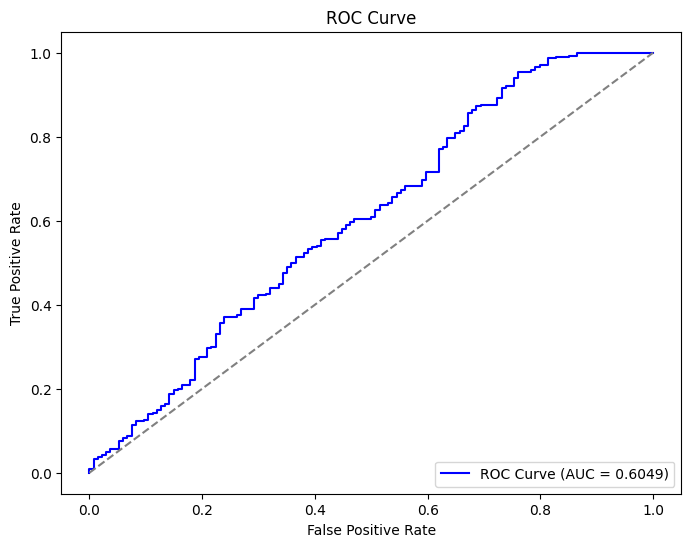

In [35]:
evaluator.display_metrics()